## Set Up Session

In [1]:
# Configuration:
from behavioral_cloning.utils.conf import Conf
# ETL:
import numpy as np
from behavioral_cloning.utils.dataset import Dataset
from sklearn.model_selection import train_test_split
# Preprocessing:
import cv2
from behavioral_cloning.preprocessors import Preprocessor
# Modeling:
from keras.models import Sequential
from keras.layers.core import Lambda, Dropout, Flatten, Dense 
from keras.layers.convolutional import Cropping2D, Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
# Visualization:
import matplotlib.pyplot as plt
from behavioral_cloning.utils.visualization import draw_steering_distributions
%matplotlib inline

Using TensorFlow backend.


## Load Configuration

In [2]:
conf = Conf('conf/conf.json')

## Training/Testing Split

#### Load Dataset

In [3]:
X, y = [], []

preprocessor = Preprocessor(
    output_size=tuple(conf.preprocessor_output_size)
)
for dataset_dir in conf.datasets:
    # Initialize dataset accessor:
    dataset = Dataset(
        dataset_dir,
        steering_correction = 0.25
    )
    
    for (images, steerings) in iter(dataset):
        # Crop & resize to reduce memory footprint:
        processed = preprocessor.transform(images)
        
        # Add to dataset:
        X.append(processed)
        y.append(steerings)

X = np.vstack(X)
y = np.hstack(y)

#### Visualize Augmented Images

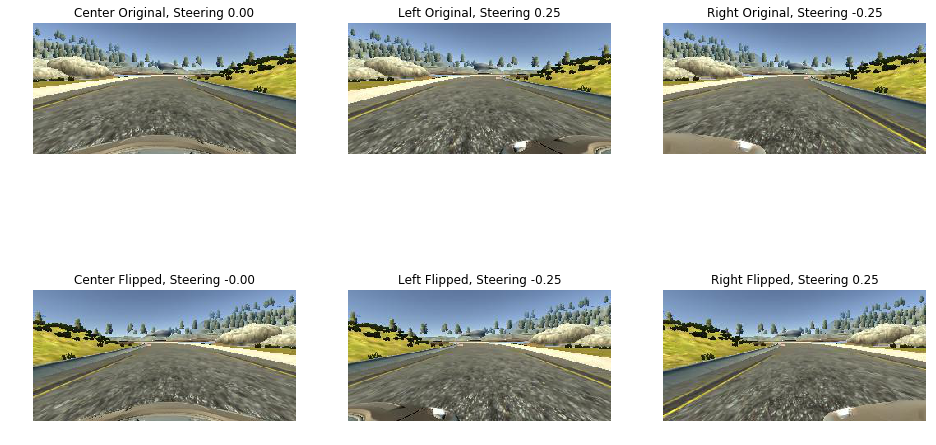

In [4]:
# Initialize canvas:
augmentation_demo = plt.figure(figsize=(16, 9))
 
for idx, image_type in enumerate(
    (
        "Center Original",
        "Left Original",
        "Right Original",
        "Center Flipped",
        "Left Flipped",
        "Right Flipped"        
    )
):
    image = cv2.cvtColor(
        images[idx],
        cv2.COLOR_BGR2RGB
    )
    steering = steerings[idx]
    
    ax=augmentation_demo.add_subplot(2,3,idx + 1)
    ax.set_axis_off()
    plt.imshow(image)
    ax.set_title(
        "{}, Steering {:.2f}".format(image_type, steering)
    )

#### Visualize Preprocessed Images

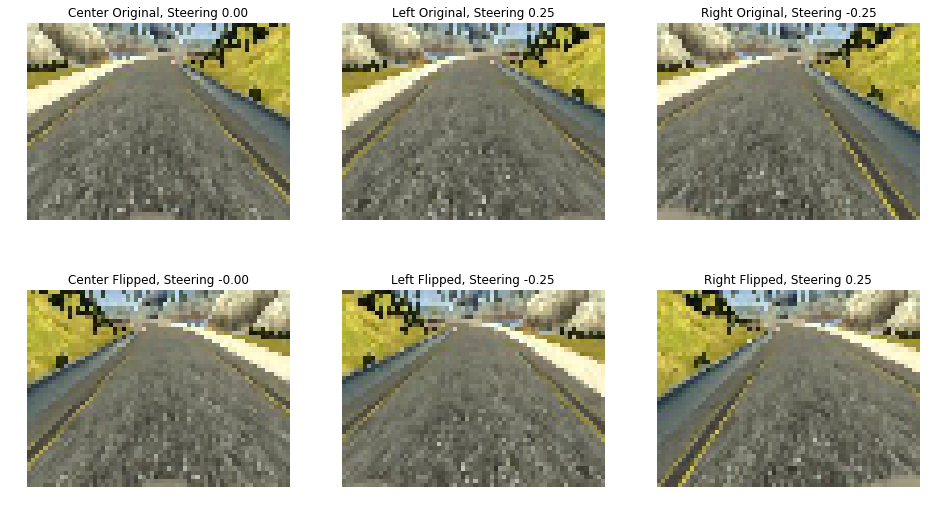

In [5]:
# Initialize canvas:
preprocessing_demo = plt.figure(figsize=(16, 9))
 
for idx, image_type in enumerate(
    (
        "Center Original",
        "Left Original",
        "Right Original",
        "Center Flipped",
        "Left Flipped",
        "Right Flipped"        
    )
):
    image = cv2.cvtColor(
        X[idx-6],
        cv2.COLOR_BGR2RGB
    )
    steering = y[idx-6]
    
    ax=preprocessing_demo.add_subplot(2,3,idx + 1)
    ax.set_axis_off()
    plt.imshow(image)
    ax.set_title(
        "{}, Steering {:.2f}".format(image_type, steering)
    )

#### Visualize Steering Distribution

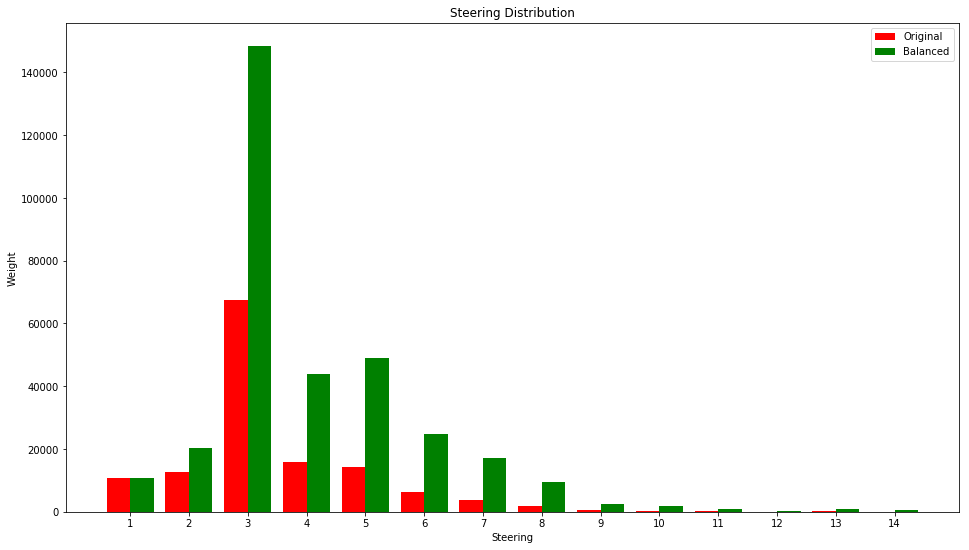

In [7]:
draw_steering_distributions(y, ratio=0.6)

#### Split Training & Testing Subsets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.05, 
    random_state=42
)

## Build Network

#### Configurations

In [3]:
INPUT_SHAPE = tuple(conf.model_input_size)
N_OUTPUT = 1

BATCH_SIZE = 512
N_EPOCHES = 32

#### Model Architecture

In [4]:
def resize(X):
    # Set up session:
    from keras.backend import tf as ktf
    
    return ktf.image.resize_images(X, (32, 64))

def standardize(X):
    # Set up session:
    from keras.backend import tf as ktf
    
    return ktf.map_fn(
        lambda x: ktf.image.per_image_standardization(x),
        X
    )

In [5]:
model = Sequential()

# Preprocessing:
model.add(
    Lambda(
        standardize,
        input_shape = INPUT_SHAPE
    )
)
# Convs:
model.add(
    Convolution2D(
        32, 3, 3, border_mode='same',
        activation='relu',
        init='he_normal'
    )
)
model.add(
    Convolution2D(
        48, 3, 3, border_mode='same', 
        activation='relu',
        init='he_normal'
    )
)
model.add(
    MaxPooling2D(pool_size=(2, 2))
)
model.add(
    Convolution2D(
        64, 3, 3, border_mode='same', 
        activation='relu',
        init='he_normal'
    )
)
model.add(
    MaxPooling2D(pool_size=(2, 2))
)
model.add(
    Dropout(0.25)
)
# Flatten:
model.add(
    Flatten()
)
# Fully connected:
model.add(
    Dense(
        128, 
        activation='relu',
        init='he_normal'
    )
)
model.add(
    Dense(
        64, 
        activation='relu',
        init='he_normal'
    )
)
model.add(
    Dropout(0.50)
)
# Output:
model.add(
    Dense(
        N_OUTPUT, 
        activation='linear'
    )
)

model.compile(
    loss='mean_squared_error',
    optimizer=Adam(lr=1e-3),
    metrics=['mae']
)

#### Optimization

In [9]:
def calculate_sample_weights(steering, weight_unit = 0.1, ratio = 0.5):
    """ Calculate sample weights based on steering angle
    """
    num_effective = (np.absolute(y_train) + weight_unit) / weight_unit
    
    # Try to strike a balance between straight & curve lane performance:
    weights = (1.0 - ratio) * num_effective + ratio * (num_effective**2)
    
    return weights

In [10]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=2,verbose=0
    )
]

In [11]:
model.fit(
    X_train, y_train,
    sample_weight = calculate_sample_weights(y_train, ratio = 0.6),
    batch_size = BATCH_SIZE,
    nb_epoch = N_EPOCHES,
    verbose = 1,
    shuffle=True, validation_split=0.10, callbacks=callbacks
)

Train on 41224 samples, validate on 4581 samples
Epoch 1/32
41224/41224 [==============================] - 33s - loss: 15.7840 - mean_absolute_error: 0.4748 - val_loss: 0.3810 - val_mean_absolute_error: 0.1258
Epoch 2/32
41224/41224 [==============================] - 29s - loss: 0.4160 - mean_absolute_error: 0.1472 - val_loss: 0.2874 - val_mean_absolute_error: 0.1127
Epoch 3/32
41224/41224 [==============================] - 28s - loss: 0.3339 - mean_absolute_error: 0.1361 - val_loss: 0.2631 - val_mean_absolute_error: 0.1055
Epoch 4/32
41224/41224 [==============================] - 29s - loss: 0.2970 - mean_absolute_error: 0.1294 - val_loss: 0.2389 - val_mean_absolute_error: 0.1001
Epoch 5/32
41224/41224 [==============================] - 29s - loss: 0.2681 - mean_absolute_error: 0.1250 - val_loss: 0.2168 - val_mean_absolute_error: 0.1012
Epoch 6/32
41224/41224 [==============================] - 29s - loss: 0.2495 - mean_absolute_error: 0.1213 - val_loss: 0.2081 - val_mean_absolute_erro

#### Evaluation

In [12]:
score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test mae:', score[1])

Test loss: 0.0167616111068
Test mae: 0.0964774908981


#### Save for Deployment

In [13]:
model.save('model.h5')

#### Model Architecture Visualization

In [9]:
model = load_model('model-1024-768-good.h5')

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))